# $c_p$ DREAMING EXPERIMENTS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
from rdkit import Chem
rdkit.RDLogger.DisableLog('rdApp.warning')

### Collect our input data

In [3]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [5]:
target_names = ['cp']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [10]:
train_df.head(1)

,MOFname,edge_group_selfie,node_selfie,topo,cp,tokenized_edge_selfies,edge_lens,node_plus_topo,tokenized_node_plus_topo,node_plus_topo_lens,mof_string,tokenized_mof_string,mof_string_lens
0,sxb_N265_edge4527,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,sxb,0.939584,"[16, 68, 61, 52, 60, 61, 60, 65, 52, 60, 64, 7...",31,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,"[34, 22, 48, 65, 48, 22, 20, 22, 34, 48, 65, 2...",56,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,"[20, 110, 75, 58, 74, 75, 74, 101, 58, 74, 89,...",89


# Load Language Models

In [6]:
dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'

with open('../..//train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

## Test model

(1000, 1)


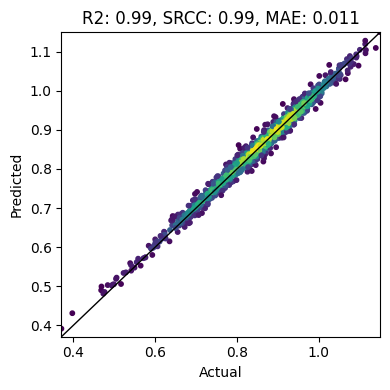

In [11]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

# Dreaming 

#### Lets visualise the attention weights

In [12]:
scaled_seed_value = [0.2]
seed_value = predictor_scaler.inverse_transform(np.array(scaled_seed_value).reshape(1, -1))
idx = train_df[target_names[0]].sub(seed_value[0][0]).abs().idxmin()
seed_mof_string = train_df.iloc[idx]['mof_string']
train_df.iloc[idx]

MOFname                                                   unc_N164_edge171771
edge_group_selfie           [Br][:3pyridine][Ring2][C][=Branch][=C][Branch...
node_selfie                 [Fr][C][O][In][Branch1][Ring2][O][Ring1][Ring2...
topo                                                                      unc
cp                                                                   0.485487
tokenized_edge_selfies      [59, 41, 69, 61, 51, 52, 60, 61, 51, 52, 68, 6...
edge_lens                                                                  23
node_plus_topo              [Fr][C][O][In][Branch1][Ring2][O][Ring1][Ring2...
tokenized_node_plus_topo    [34, 22, 48, 39, 20, 55, 48, 54, 55, 20, 6, 48...
node_plus_topo_lens                                                        39
mof_string                  [Br][:3pyridine][Ring2][C][=Branch][=C][Branch...
tokenized_mof_string        [71, 45, 111, 75, 57, 58, 74, 75, 57, 58, 110,...
mof_string_lens                                                 

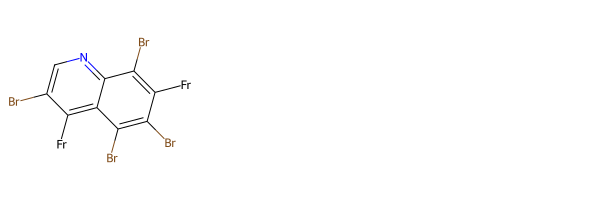

In [13]:
draw_smiles_linker([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])

In [14]:
def plot_attention_weights_1d(attention_weights, tokens, title="Attention Weights", save_fig=False):
    # Plotting
    fig, ax = plt.subplots(figsize=(5.2, 4))
    colors = ['indianred' if token == '[:3pyridine]' else 'orange' if token == '[Br]' else 'steelblue' for token in tokens]
    ax.bar(range(len(attention_weights)), attention_weights, tick_label=tokens, alpha=0.75, color=colors)
    ax.set_xticklabels(tokens, rotation=90)  # Set xticks rotation to 90 degrees
    ax.set_ylabel("Attention Weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if save_fig:
        plt.savefig('figure.png', dpi=300)
    plt.show()

torch.Size([1, 39, 73])


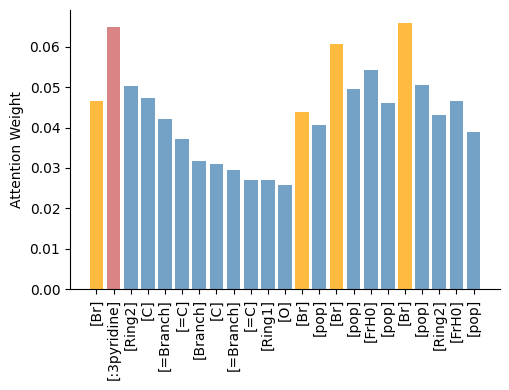

In [15]:
from dreaming_functions import predict_kpi
predicted_targets, attn_w1, attn_w2 = predict_kpi(predictor_model,seed_mof_string,tokenized_info)
edge_gs = seed_mof_string.split('[.]')[0]
len_edge_selfies = sf.len_selfies(edge_gs)
attn_edge = attn_w1.detach().numpy().flatten()[:len_edge_selfies] / np.sum(attn_w1.detach().numpy().flatten()[:len_edge_selfies])
plot_attention_weights_1d(attn_edge, list(sf.split_selfies(edge_gs)), title="Node Attention Weights", save_fig=True)

#### Lets perform a dreaming operation

In [112]:
scaled_seed_value = [0.65]
seed_value = predictor_scaler.inverse_transform(np.array(scaled_seed_value).reshape(1, -1))
target_values = [0.1]
idx = train_df[target_names[0]].sub(seed_value[0][0]).abs().idxmin()
seed_mof_string = train_df.iloc[idx]['mof_string']
train_df.iloc[idx]

edge_canon_smile                                      CS1=CNC(C)([Fr])NN1[Fr]
MOFname                                                   rob_N593_edge151995
edge_group_selfie           [FrH0][C][Branch][C][pop][:0methyl_amine][Ring...
node_selfie                 [O][=C][Branch1][C][Fr][O][Cd][Branch1][O][N][...
topo                                                                      rob
cp                                                                    0.88148
tokenized_edge_selfies      [64, 61, 60, 61, 72, 16, 68, 58, 60, 65, 60, 6...
edge_lens                                                                  19
node_plus_topo              [O][=C][Branch1][C][Fr][O][Cd][Branch1][O][N][...
tokenized_node_plus_topo    [48, 7, 20, 22, 34, 48, 23, 20, 48, 45, 22, 8,...
node_plus_topo_lens                                                        63
mof_string                  [FrH0][C][Branch][C][pop][:0methyl_amine][Ring...
tokenized_mof_string        [89, 75, 74, 75, 148, 20, 110, 64, 7

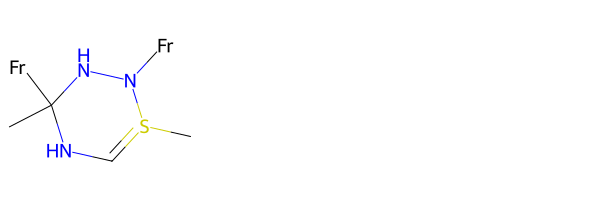

In [113]:
draw_smiles_linker([train_df.iloc[idx]['edge_canon_smile']])

In [118]:
dream_settings = {
    'num_epochs': 5000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }
valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings
    )

torch.Size([1, 39, 73])
Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\deep_dreaming_MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.6377655] | target value: [0.1] | opt_flag: ['min']


opt flag: min, all targets: [0.5791663], valid linker, valid distance point
opt flag: min, all targets: [0.578094], valid linker, valid distance point
opt flag: min, all targets: [0.5160379], valid linker, valid distance point
opt flag: min, all targets: [0.45506495], valid linker, valid distance point
opt flag: min, all targets: [0.3923396], valid linker, valid distance point
opt flag: min, all targets: [0.38129434], valid linker, valid distance point
opt flag: min, all targets: [0.34975135], valid linker, valid distance point
opt flag: min, all targets: [0.19033441], valid linker, valid distance point
Finished Training


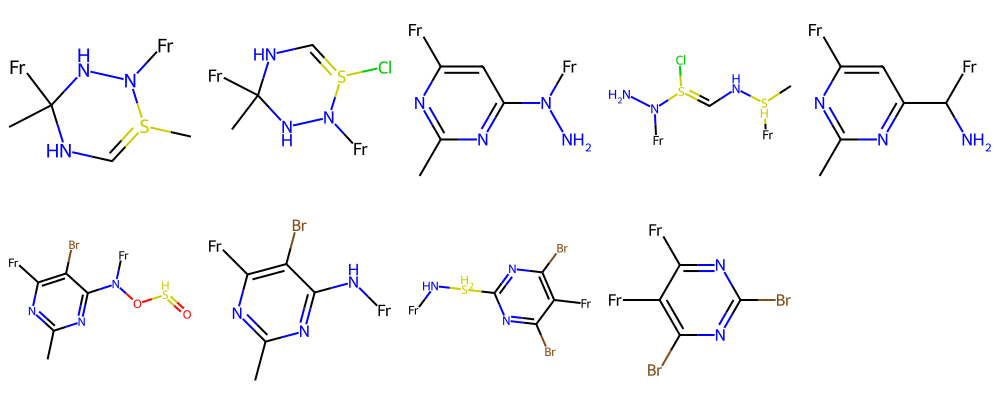

In [120]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=5,subImgSize=(200, 200),line_width=2)

#### Shited property distributions

In [ ]:
# ******************* EXAMPLE CELL TO OPTIMISE CP DISTRIBUTION *******************

# Seed distribution
cp_seed = pd.read_csv(('../seeds/cp_1100_seed_df.csv'))
target_values = [0]     # cp_min

# Dream settings
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

# Perform dreaming for a distribution of cp MOFs
dream_results = []
exceptions = []
start, stop = 0, 10
count = 0
for i in range(start,stop): #range(len(encoding_df)): 
    print(i)
    try:
        global_opt_pathways = []
        for j in range(10): 
            seed_mof_string = cp_seed.iloc[i]['mof_string']
            opt_mof_string = seed_mof_string
            local_valid_opt_pathway = run_dream_exp(
                dreaming_model, 
                predictor_model, 
                opt_mof_string, 
                target_values, 
                tokenized_info, 
                group_grammar, 
                dream_settings,
                iterations=5
                )
            global_opt_pathways.append(local_valid_opt_pathway)
        
        # extract the pathway with the best target value (ensemble of local optimisations)
        if target_values[0] <= 0:
            valid_opt_pathway = global_opt_pathways[np.argmin([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        elif target_values[0] >= 1:
            valid_opt_pathway = global_opt_pathways[np.argmax([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        else:
            raise ValueError('Target value must be <= 0 or >= 1')

        # store results in new dataframe
        dream_results.append({
            'seed_mof_name': cp_seed.iloc[i]['MOFname'],
            'seed_mof_string': seed_mof_string,
            'seed_edge_selfies': cp_seed.iloc[i]['edge_group_selfie'],
            'seed_target': cp_seed.iloc[i][target_names[0]],
            'dreamed_mof_string': valid_opt_pathway.iloc[-1]['dreamed_mof_string'],
            'dreamed_edge_selfies': valid_opt_pathway.iloc[-1]['dreamed_selfies'],
            'dreamed_edge_smiles': valid_opt_pathway.iloc[-1]['dreamed_smiles'],
            'dreamed_target': scaler.inverse_transform(np.array(valid_opt_pathway.iloc[-1]['predictor_targets'][0]).reshape(1, -1)).item(),
        })
        count += 1
        if count % 5 == 0:
            dream_results_df = pd.DataFrame(dream_results)
            dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')    	
    except Exception as e:
        exceptions.append(e)
        continue
dream_results_df = pd.DataFrame(dream_results)
dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')

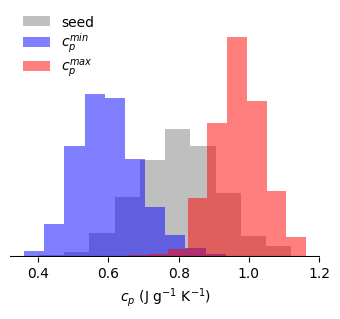

In [16]:
# Visualise the results for 1000 MOFs
min_results = pd.read_csv('./dream_results/cp_min_1000_dream_results.csv')
max_results = pd.read_csv('./dream_results/cp_max_1000_dream_results.csv')

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(max_results['seed_target'], bins=10,color='grey',alpha=0.5,density=True,label='seed')
ax.hist(min_results['dreamed_target'],bins=10,alpha=0.5,density=True,label='$c_p^{min}$',color='blue')
ax.hist(max_results['dreamed_target'],bins=10,alpha=0.5,density=True,label='$c_p^{max}$',color='red')
ax.set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
plt.box(False)
ax.tick_params(left=False, labelleft=False)
ax.axhline(y=0, color='black', linestyle='-')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(0, 1.1),labelspacing=0.15)
fig.savefig('cp_hist.png',dpi=500,bbox_inches="tight")

#### tSNE projection of 10,000 dreamed MOFs

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils import compute_fingerprints

max_results = pd.read_csv(f'./dream_results/cp_max_10000_dream_results.csv',index_col=[0])
min_results = pd.read_csv(f'./dream_results/cp_min_10000_dream_results.csv',index_col=[0])

# Generate fingerprints
max_generated_fps = compute_fingerprints(max_results['dreamed_edge_smiles'].tolist())
min_generated_fps = compute_fingerprints(min_results['dreamed_edge_smiles'].tolist())
reference_fps = compute_fingerprints(training_data['edge_canon_smile'].tolist())

# Combine fingerprints
all_fps = np.array(max_generated_fps + min_generated_fps + reference_fps)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=200, learning_rate=50, random_state=42)
reduced_data = tsne.fit_transform(all_fps)

# Split the transformed data for plotting
max_transformed_generated = reduced_data[:len(max_generated_fps), :]
min_transformed_generated = reduced_data[len(max_generated_fps):len(max_generated_fps)+len(min_generated_fps), :]
transformed_reference = reduced_data[len(max_generated_fps)+len(min_generated_fps):, :]

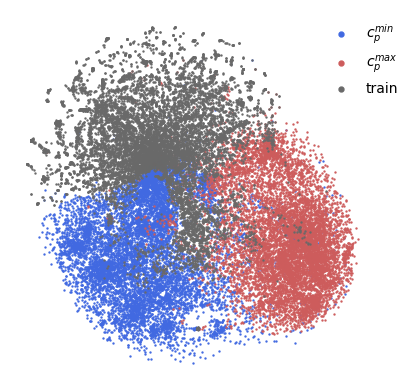

In [20]:
fig,ax=plt.subplots(1,1,figsize=(4.2,4))
ax.scatter(min_transformed_generated[:, 0], min_transformed_generated[:, 1], color='royalblue',s=.5,label='$c_p^{min}$',alpha=1)
ax.scatter(max_transformed_generated[:, 0], max_transformed_generated[:, 1], color='indianred',s=.5,label='$c_p^{max}$',alpha=1)
ax.scatter(transformed_reference[:, 0], transformed_reference[:, 1], color='dimgrey',s=.5,label='train',alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper right', markerscale=5,frameon=False)
ax.tick_params(left=False, labelleft=False)
ax.tick_params(bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()
fig.savefig('cp_tSNE.png',dpi=500,bbox_inches="tight")